In [43]:
import pandas as pd, numpy as np
from pathlib import Path

DATA = Path("../MLPC2025_dataset")
ann  = pd.read_csv(DATA / "annotations.csv")
tvec = np.load(DATA / "annotations_text_embeddings.npz")["embeddings"]  # (35826, 1024)

print("annotations :", len(ann))
print("embeddings  :", tvec.shape)
assert len(ann) == tvec.shape[0], "Number of annotations and embeddings do not match"
ann.head()

annotations : 35826
embeddings  : (35826, 1024)


,task_id,filename,annotator,text,onset,offset,filename_unsafe
0,161977861,560761.mp3,5945971035380930099053858595454362549806990533...,bird twitters nearby with a high pitch two times,16.552368,17.271435,560761_tufted titmouse calling.mp3
1,161987165,240538.mp3,4916274343929406460752597829190197300566135449...,A cow bell clinging repeatedly,12.265866,15.420303,240538_AMB - Cowbell stable Stereowav.mp3
2,161989998,660337.mp3,8960534646813062318784592632173589349806817458...,A child speaks with a high-pitched voice,12.493984,13.315680,660337_Aeroplane Takeoff From Cabinwav.mp3
3,161978339,725686.mp3,4540509031938851510799116530500792274849113758...,A high pitch meowing coming from a cat,16.018221,16.991704,725686_Black Cat Talking.mp3
4,161985729,97606.mp3,1085174475307080254018414698413953957857995126...,An extremely loud brushing sound on a construc...,0.000000,1.626352,97606_jackhammer med distwav.mp3


In [44]:
dog_re = r"\b(?:dog|bark|woof|puppy)\b"
cat_re = r"\b(?:cat|meow|purr|kitten)\b"

dog_mask = ann.text.str.contains(dog_re, case=False, na=False)
cat_mask = ann.text.str.contains(cat_re, case=False, na=False)

print("dog rows :", dog_mask.sum())
print("cat rows :", cat_mask.sum())

dog rows : 1505
cat rows : 741


In [45]:
norms = np.linalg.norm(tvec, axis=1); print(norms.mean(), norms.std())

1.0 3.334734e-08


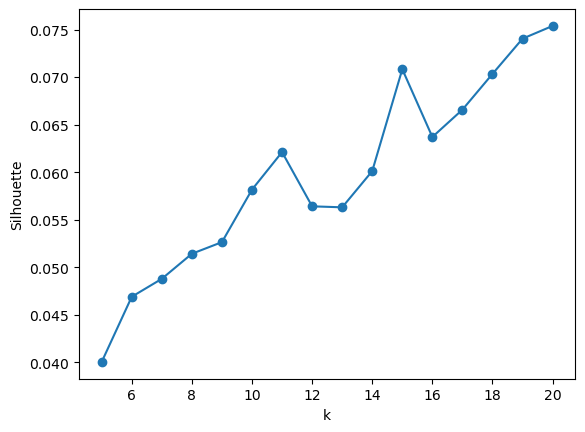

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = tvec if np.isclose(norms, 1, atol=1e-3).all() else StandardScaler().fit_transform(tvec)
Xp = PCA(n_components=0.9, random_state=0).fit_transform(X)    

ks, sil = [], []
for k in range(5, 21):
    lab = KMeans(k, random_state=0, n_init='auto').fit(Xp).labels_
    ks.append(k); sil.append(silhouette_score(Xp, lab))
plt.plot(ks, sil, 'o-'); plt.xlabel('k'); plt.ylabel('Silhouette'); 
plt.savefig("figs_tang/04_silhouette_k.pdf")
plt.show()

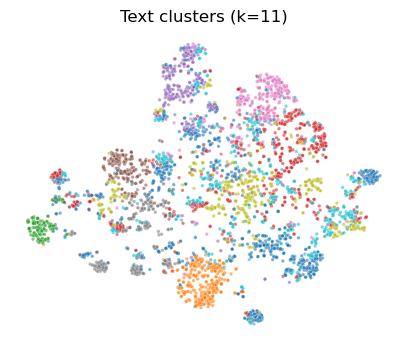

In [55]:
from sklearn.manifold import TSNE
import seaborn as sns

k_best = 11      
km = KMeans(k_best, random_state=0, n_init='auto').fit(Xp)
ann["t_cluster"] = km.labels_

idx = np.random.choice(len(Xp), 4000, replace=False)
ts = TSNE(perplexity=40, random_state=0).fit_transform(Xp[idx])

plt.figure(figsize=(5,4))
sns.scatterplot(x=ts[:,0], y=ts[:,1],
                hue=ann.t_cluster.values[idx], palette='tab10', s=6, alpha=.6, legend=False)
plt.title("Text clusters (k=%d)"%k_best); plt.axis('off')
plt.savefig("figs_tang/04_text_cluster11.pdf")
plt.show()

ann.to_csv("output_tang/annotations_with_tcluster.csv", index=False)

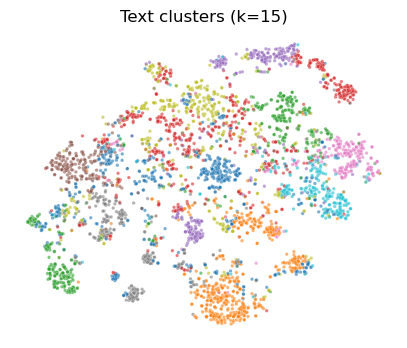

In [56]:
from sklearn.manifold import TSNE
import seaborn as sns

k_best = 15      
km = KMeans(k_best, random_state=0, n_init='auto').fit(Xp)
ann["t_cluster"] = km.labels_

idx = np.random.choice(len(Xp), 4000, replace=False)
ts = TSNE(perplexity=40, random_state=0).fit_transform(Xp[idx])

plt.figure(figsize=(5,4))
sns.scatterplot(x=ts[:,0], y=ts[:,1],
                hue=ann.t_cluster.values[idx], palette='tab10', s=6, alpha=.6, legend=False)
plt.title("Text clusters (k=%d)"%k_best); plt.axis('off')
plt.savefig("figs_tang/04_text_cluster15.pdf")
plt.show()

ann.to_csv("output_tang/annotations_with_tcluster.csv", index=False)

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np, math, pandas as pd

def dog_entropy(labels):
    ent = 0
    for cid in np.unique(labels):
        p = dog_mask[labels==cid].mean()
        if 0 < p < 1:
            ent += -(p*math.log2(p)+(1-p)*math.log2(1-p))
    return ent / len(np.unique(labels))

metrics = []
for k in (11, 15):
    km = KMeans(k, random_state=0, n_init='auto').fit(Xp)
    lab = km.labels_
    sil = silhouette_score(Xp, lab)
    sizes = pd.Series(lab).value_counts().values
    size_ratio = sizes.std()/sizes.mean()
    de = dog_entropy(lab)
    metrics.append((k, sil, size_ratio, de))

print(pd.DataFrame(metrics, columns=["k","silhouette","size_σ/μ","dog_entropy"]))

    k  silhouette  size_σ/μ  dog_entropy
0  11    0.062126  0.410545     0.093540
1  15    0.070824  0.436611     0.077069


In [60]:
k_best = 15
km = KMeans(k_best, random_state=0, n_init='auto').fit(Xp)
ann["t_cluster"] = km.labels_
ann.to_csv("output_tang/ann_with_tcluster_k15.csv", index=False)

In [61]:
import re, numpy as np
from sklearn.metrics.pairwise import cosine_similarity

DOG_RE = re.compile(r"\b(?:dog|bark|woof|puppy|growl|howl)\b", re.I)
CAT_RE = re.compile(r"\b(?:cat|meow|kitten|miaow|purr)\b", re.I)

dog_regex = ann.text.str.contains(DOG_RE, na=False)
cat_regex = ann.text.str.contains(CAT_RE, na=False)

proto_dog = tvec[dog_regex].mean(axis=0, keepdims=True)
proto_cat = tvec[cat_regex].mean(axis=0, keepdims=True)

cos_dog = cosine_similarity(tvec, proto_dog).ravel()
cos_cat = cosine_similarity(tvec, proto_cat).ravel()

THRESH = 0.35    
ann["is_dog"] = dog_regex & (cos_dog > THRESH)
ann["is_cat"] = cat_regex & (cos_cat > THRESH)

print("LF → dog:", ann.is_dog.sum(), " cat:", ann.is_cat.sum())

LF → dog: 1483  cat: 731


dog  entropy : 0.07287346713091038
cat  entropy : 0.07338898063623932


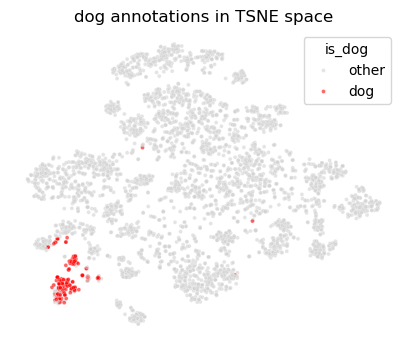

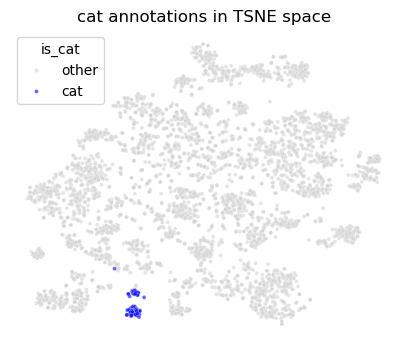

In [62]:
def cluster_entropy(mask):
    import math
    ent = 0
    for cid, grp in ann.groupby("t_cluster"):
        p = mask[grp.index].mean()
        if 0 < p < 1:
            ent += -(p*math.log2(p) + (1-p)*math.log2(1-p))
    return ent / ann.t_cluster.nunique()

print("dog  entropy :", cluster_entropy(ann.is_dog))
print("cat  entropy :", cluster_entropy(ann.is_cat))

idx = np.random.choice(len(Xp), 4000, replace=False)
ts  = TSNE(perplexity=40, random_state=1).fit_transform(Xp[idx])

import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(5,4))
sns.scatterplot(x=ts[:,0], y=ts[:,1],
                hue=ann.is_dog.iloc[idx].map({True:"dog", False:"other"}),
                palette=['lightgrey','red'], s=8, alpha=.6)
plt.title("dog annotations in TSNE space"); plt.axis('off'); 
plt.savefig("figs_tang/04_dog_annotations_in_tsne_space.pdf")
plt.show()

idx = np.random.choice(len(Xp), 4000, replace=False)
ts  = TSNE(perplexity=40, random_state=1).fit_transform(Xp[idx])

import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(5,4))
sns.scatterplot(x=ts[:,0], y=ts[:,1],
                hue=ann.is_cat.iloc[idx].map({True:"cat", False:"other"}),
                palette=['lightgrey','blue'], s=8, alpha=.6)
plt.title("cat annotations in TSNE space"); plt.axis('off'); 
plt.savefig("figs_tang/04_cat_annotations_in_tsne_space.pdf")
plt.show()

Matched rows: 39835
Text‑Audio NMI: 0.04


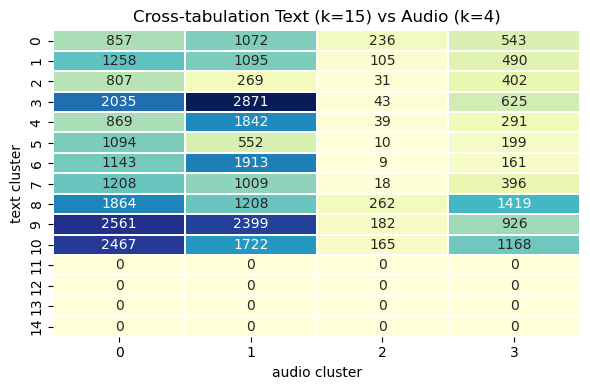

In [63]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import normalized_mutual_info_score

ann = pd.read_csv("output_tang/annotations_with_tcluster.csv")     
audio_vec = np.load("output_tang/audio_region_vectors.npz", allow_pickle=True)
audio_clu = np.load("output_tang/region_clusters.npz", allow_pickle=True)["cluster"]

is_event = audio_vec["is_event"]
event_idx = np.where(is_event == 1)[0]

aud_df = pd.DataFrame({
    "filename": audio_vec["filenames"][event_idx],
    "onset_r" : np.round([r[0] for r in audio_vec["regions"][event_idx]], 3),
    "offset_r": np.round([r[1] for r in audio_vec["regions"][event_idx]], 3),
    "a_cluster": audio_clu[event_idx]
})

ann["onset_r"]  = np.round(ann["onset"], 3)
ann["offset_r"] = np.round(ann["offset"], 3)

merged = pd.merge(
    ann, aud_df,
    on=["filename", "onset_r", "offset_r"],
    how="inner"
)
print("Matched rows:", len(merged))   

nmi = normalized_mutual_info_score(merged.t_cluster, merged.a_cluster)
print("Text‑Audio NMI:", round(nmi, 3))

ct_full = ct.reindex(range(15), fill_value=0)   

plt.figure(figsize=(6,4))
sns.heatmap(ct_full, cmap="YlGnBu", linewidths=.3,
            annot=True, fmt='d', cbar=False)
plt.xlabel("audio cluster")
plt.ylabel("text cluster")
plt.title("Cross‑tabulation Text (k=15) vs Audio (k=4)")
plt.tight_layout()
plt.savefig("figs_tang/04_text_audio_heatmap_k15.pdf")
plt.show()

In [ ]:
import pandas as pd, numpy as np
from pathlib import Path
import random

SAMPLES_PER_CLUSTER = 5
records = []

for cid in range(15):
    pool = merged[ merged.t_cluster == cid ]
    if len(pool) == 0:
        print(f"cluster {cid}: 0 rows, skipped")
        continue
    chosen = pool.sample(min(SAMPLES_PER_CLUSTER, len(pool)), random_state=0)
    for _, row in chosen.iterrows():
        records.append({
            "t_cluster": int(cid),
            "filename" : row.filename,
            "onset"    : round(row.onset, 2),
            "offset"   : round(row.offset, 2),
            "your_notes": ""          
        })

sample_df = pd.DataFrame(records)
Path("outputs").mkdir(exist_ok=True)
sample_df.to_csv("output_tang/text_cluster_samples.csv", index=False)
print("Saved output_tang/text_cluster_samples.csv with", len(sample_df), "rows")

Saved output_tang/text_cluster_samples.csv with 75 rows


In [ ]:
import pandas as pd, textwrap

notes = pd.read_csv("output_tang/text_cluster_samples.csv")

summary = (notes.groupby("t_cluster")["your_notes"]
                 .apply(lambda x: ", ".join(sorted(set(k.strip() for k in x))))
                 .reset_index()
                 .rename(columns={"t_cluster":"cluster", "your_notes":"keywords"}))

from IPython.display import display
display(summary)

,cluster,keywords
0,0,"bicycle bell, church bells, train/church bells..."
1,1,"electric buzzer, mosquito buzzing, people talk..."
2,2,"bird chirping, dog barking, dog barking and bi..."
3,3,"engine sound with water flows background, heav..."
4,4,"dripping water, electricity sound, fire and en..."
5,5,"people reading, people singing, people speaking"
6,6,"airplane engine sound, electric saw, motor veh..."
7,7,bird chirping and people talking in background...
8,8,"coughing, drill sound, drum sound, piano echo,..."
9,9,"airplane far away, dog barking far away, engin..."
